In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, Conv2D, LeakyReLU
from keras.optimizers import Adam
from google.colab import drive


In [ ]:
os.makedirs("celeba_gan")
drive.mount('/content/drive')
url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)


with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

Mounted at /content/drive


In [ ]:
if not os.path.exists('/content/drive/My Drive/my_folder'):
    os.makedirs('/content/drive/My Drive/my_folder')
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(128, 128), batch_size=32
)

print(tf.data.experimental.cardinality(dataset))
dataset = dataset.take(5000)
print(tf.data.experimental.cardinality(dataset))
dataset = dataset.map(lambda x: x / 255.0)



Found 202599 files belonging to 1 classes.
tf.Tensor(6332, shape=(), dtype=int64)
tf.Tensor(5000, shape=(), dtype=int64)


In [ ]:
def build_discriminator():
    discriminator = keras.Sequential(
    [
        keras.Input(shape=(128, 128, 3)),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
    discriminator.summary()
    return discriminator

In [ ]:
def build_generator(latent_dim):
   
   generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="same", activation="sigmoid"),
    ],
    name="generator",
    )
   generator.summary()
   return generator

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, latent_dim=128):
        self.num_img = 1
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        img = keras.preprocessing.image.array_to_img(generated_images[0])
        img.save("/content/drive/My Drive/my_folder/generated_img_%03d.png" % epoch)


In [ ]:
discriminator = build_discriminator()
# Crear el generador
generator = build_generator(128)
epochs = 30  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=128)


    
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)
gan.built=True
if not os.path.exists('/content/drive/My Drive/checkpoint'):
    os.makedirs('/content/drive/My Drive/checkpoint')
history = gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(latent_dim=128)]
)


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 64, 64, 128)       6272      
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 64, 64, 128)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 flatten_5 (Flatten)         (None, 32768)           

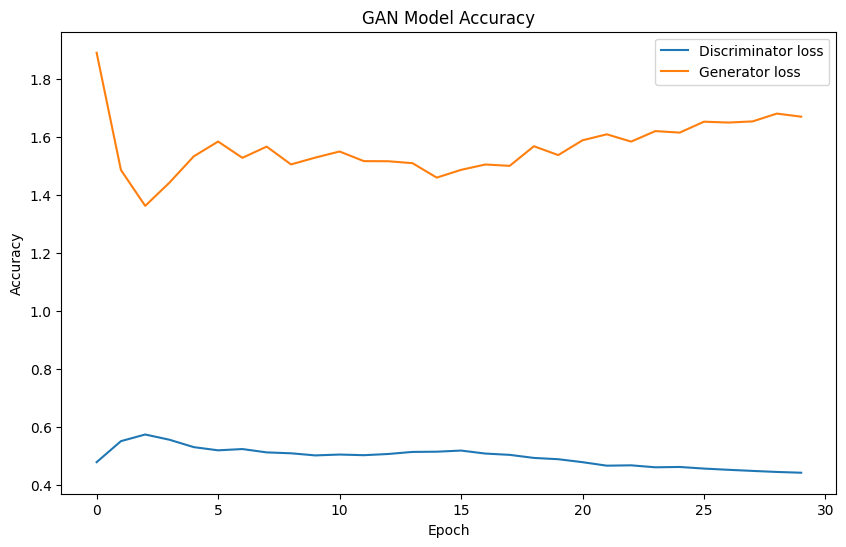

In [ ]:
# Get the discriminator and generator losses from the history
d_loss = history.history['d_loss']
g_loss = history.history['g_loss']

# Create a figure and set its size
plt.figure(figsize=(10, 6))

# Plot the discriminator and generator losses over time
plt.plot(d_loss, label='Discriminator loss')
plt.plot(g_loss, label='Generator loss')

# Add a title and axis labels
plt.title('GAN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Add a legend
plt.legend()

# Show the plot
plt.show()
